# Tephra2 Inversion: End‑to‑End, Three Methods (MCMC · SA · EnKF)

This notebook runs a full inversion workflow for **Cerro Negro** using **Tephra2** as the forward model and three complementary inverse methods:

* **MCMC (Metropolis–Hastings):** samples from the posterior distribution (uncertainty‑aware).
* **SA (Simulated Annealing):** mode‑seeking optimizer (find a good solution fast).
* **EnKF (Ensemble Kalman, smoother style):** ensemble updates over several “assimilation passes” (efficient and practical).

In [1]:
import os, logging
os.environ["TQDM_DISABLE"] = "0"
os.environ["TQDM_NOTEBOOK"] = "0"
logging.getLogger("matplotlib").setLevel(logging.WARNING)

import pandas as pd
pd.options.display.float_format = '{:,.6f}'.format

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "DejaVu Sans"

from pathlib import Path
import numpy as np

# Data Prep: Cerro Negro

We fetch and standardize a small teaching dataset into `data/input/`:

* `sites.csv` — (E, N, Z) station coordinates.
* `observations.csv` — observed mass loading per station.
* `wind.txt` — vertical wind profile for Tephra2.
* `tephra2.conf` — a template config we edit per iteration.

No extra clicks: this cell downloads once, then reuses local files. If a file is missing, re‑run this cell.

In [2]:
!python scripts/data_handling/download_cerro_negro.py --prepare

Downloading:
  https://gscommunitycodes.usf.edu/geoscicommunitycodes/public/inversion-shortcourse/tephra2-inv3/tephra2-inversion3-victor.zip
→ /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/cerro_negro/tephra2-inversion3-victor.zip
  0.9 / 0.9 MB (100.0%)
Download complete.
Unzipping:
  /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/cerro_negro/tephra2-inversion3-victor.zip
→ /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/cerro_negro
Unzip complete.
Removed ZIP: /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/cerro_negro/tephra2-inversion3-victor.zip

Prepared working inputs:
  observations: /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/observations.csv
  sites: /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/sites.csv
  wind: /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/wind.txt
  conf: /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input/tephra2.conf

Done.


# Imports & Plotting Helpers

We load the unified **TephraInversion** wrapper and a few plot helpers:

* **ObservationPlotter**: site map & deposit magnitudes.
* **WindPlotter**: speed & direction vs height.
* **DiagnosticPlotter**: traces + marginals for any method.
* **summary\_for\_methods**: tidy comparison table.
* **scatter\_2d\_progress**: low‑alpha clouds in parameter space.
* **enkf\_pass\_2x2**: per‑pass traces (top) + per‑pass marginals (bottom) for EnKF.

> The notebook uses **defaults** from `config/default_config.py`. You can override via `TephraInversion(config={...})`, but try defaults first.

In [13]:
# Imports (after prepare so local package paths resolve cleanly)
from scripts.tephra_inversion import TephraInversion
from scripts.visualization.observation_plots import ObservationPlotter
from scripts.visualization.wind_plots import WindPlotter
from scripts.visualization.diagnostic_plots import DiagnosticPlotter
from scripts.visualization.summary import summary_for_methods
from scripts.visualization.comparative_plots import scatter_2d_progress
from scripts.visualization.enkf_pass_plots import enkf_pass_2x2

# Quick Sanity Plots: Observations & Wind

Before inverting, always look at the inputs:

* **Observed deposits**: does the spatial pattern make sense?
* **Wind profile**: is the shear/direction plausible at plume heights?

We try to pull a **vent** from `tephra2.conf`. If not present, we use the **site centroid** (good enough for a quick look).

**What to look for**

* Outlier stations with unrealistically high/low mass.
* Wind profiles with missing levels or zeros where speed shouldn’t be zero.

If something looks wrong here, **fix data first**—inversion will only amplify bad inputs.

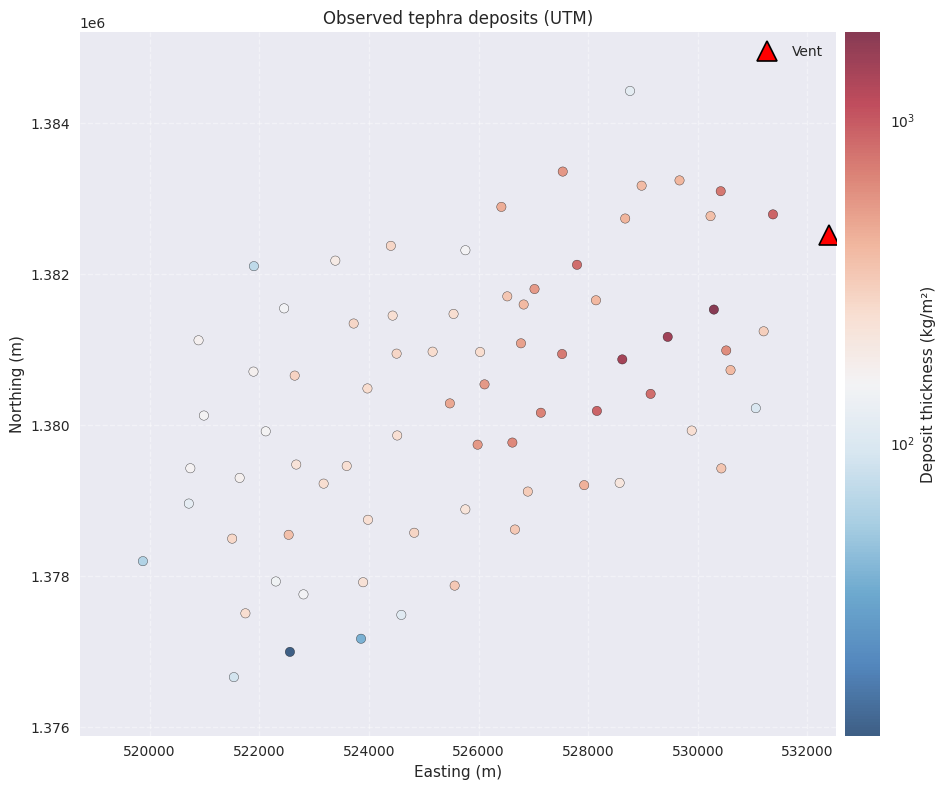

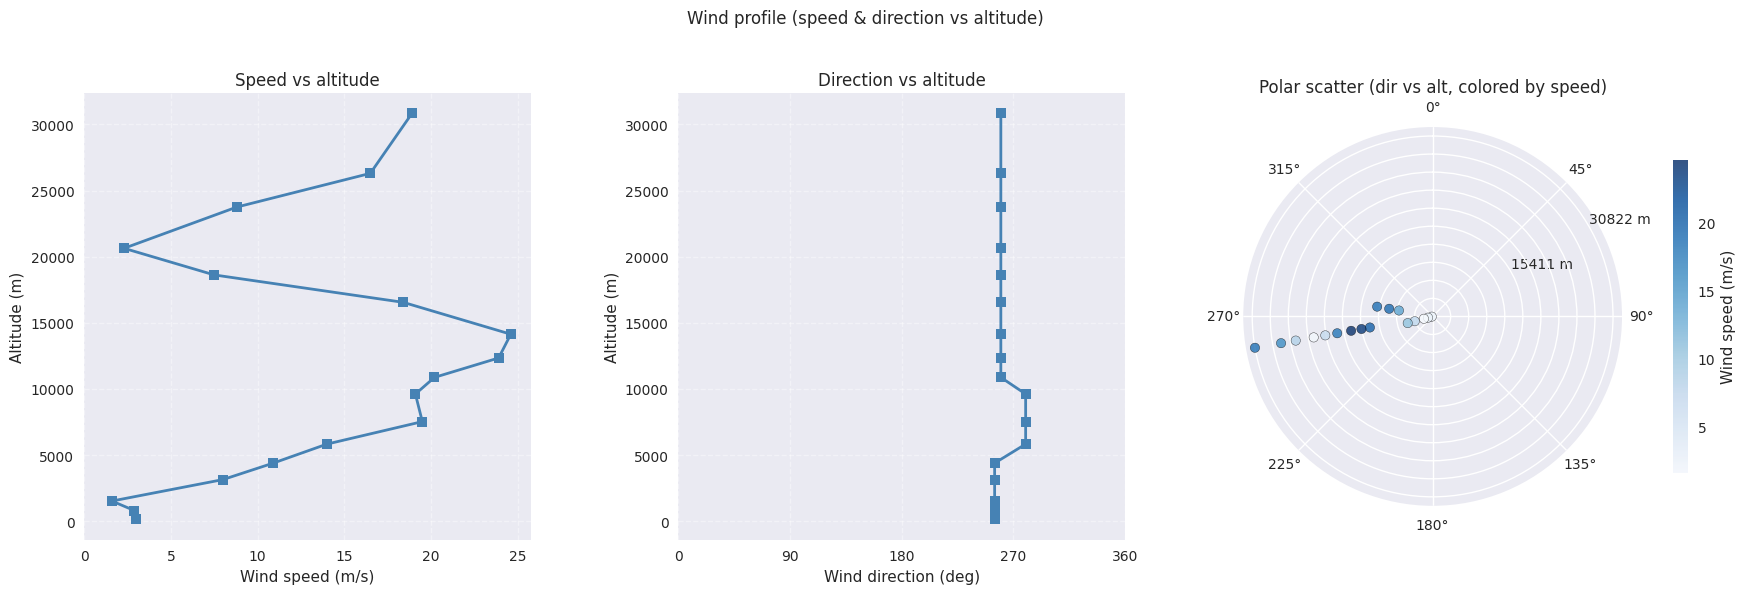

'data/output/plots/wind_profile.png'

In [4]:
# Quick input sanity visuals
sites = np.loadtxt("data/input/sites.csv")
obs   = np.loadtxt("data/input/observations.csv")
wind  = pd.read_csv("data/input/wind.txt", sep=r"\s+", comment="#", header=None,
                    names=["HEIGHT","SPEED","DIRECTION"], engine="python")

op = ObservationPlotter(output_dir="data/output/plots")
vent_xy = None
try:
    txt = Path("data/input/tephra2.conf").read_text().splitlines()
    ve = [ln for ln in txt if ln.strip().startswith("VENT_EASTING")]
    vn = [ln for ln in txt if ln.strip().startswith("VENT_NORTHING")]
    if ve and vn:
        vent_xy = (float(ve[0].split()[1]), float(vn[0].split()[1]))
except Exception:
    pass

op.plot_tephra_distribution(
    eastings=sites[:,0], northings=sites[:,1], thicknesses=obs,
    vent_location=vent_xy if vent_xy else (sites[:,0].mean(), sites[:,1].mean()),
    title="Observed tephra deposits (UTM)",
    save_path="data/output/plots/observed_tephra.png",
    show_plot=True
)

wp = WindPlotter(output_dir="data/output/plots")
wp.plot_wind_profile(
    heights=wind["HEIGHT"].to_numpy(),
    speeds=wind["SPEED"].to_numpy(),
    directions=wind["DIRECTION"].to_numpy(),
    title="Wind profile (speed & direction vs altitude)",
    save_path="data/output/plots/wind_profile.png",
    show_plot=True
)

# Plot Helper: summarize\_and\_plot()

This utility makes:

1. **Trace/ensemble** plots,
2. **Marginal** distributions.

Notes:

* For **MCMC**, traces reflect **Markov chain evolution** (should “mix” and wander around).
* For **SA**, the “trace” is a single **optimization trajectory** (tends to get stuck once cool).
* For **EnKF**, the “trace” is the **ensemble cloud** (not a posterior sample, but a diagnostic of where the algorithm pushes the ensemble).

**Interpreting plots**

* Traces: stable ranges without long drifts suggest convergence (for MCMC).
* Marginals: avoid overly tight peaks unless data are truly that constraining.

In [5]:
def summarize_and_plot(title_prefix: str, results: dict, outdir: str = "data/output/plots"):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    plotter = DiagnosticPlotter(output_dir=outdir)

    chain_df = results["chain"]
    samples = {col: chain_df[col].values for col in chain_df.columns}
    burnin = results.get("burnin", 0)

    t1 = f"{title_prefix} - Trace/Ensemble"
    t2 = f"{title_prefix} - Marginals"
    plotter.plot_trace(
        samples, burnin,
        title=t1,
        save_path=f"{outdir}/{title_prefix.lower().replace(' ','_')}_trace.png",
    )
    plotter.plot_parameter_distributions(
        samples, burnin,
        title=t2,
        save_path=f"{outdir}/{title_prefix.lower().replace(' ','_')}_marginals.png",
    )

    print(f"\n{title_prefix} summary")
    print("------------------------")
    if "best_params" in results:
        bp = results["best_params"]
        try:
            print("Point estimate:\n", bp.to_string(float_format=lambda v: f"{v:.6f}"))
        except Exception:
            print("Point estimate:\n", {k: f"{v:.6f}" for k, v in dict(bp).items()})
    if "acceptance_rate" in results and np.isfinite(results["acceptance_rate"]):
        print(f"Acceptance rate: {results['acceptance_rate']:.3f}")

# MCMC (Metropolis–Hastings)

**What it does.** Proposes a new parameter vector $\theta'$ and accepts with probability

$$
\alpha = \min\{1,\ \exp(\log p(\theta'|y) - \log p(\theta|y))\}.
$$

Here $\log p(\theta|y) = \log p(y|\theta) + \log p(\theta)$.

**Likelihood in log‑space.** We compare **log ratios** of observed vs predicted mass loading:

$$
\log p(y|\theta) \propto -\tfrac{1}{2}\sum_i \left(\frac{\log y_i - \log \hat{y}_i(\theta)}{\sigma}\right)^2.
$$

This is robust when values span orders of magnitude.

**Key settings (defaults):**

* `n_iterations=5000` (demo‑size),
* `likelihood_sigma=0.6` (controls how “tight” the fit is),
* step sizes from `config/default_config.py`.

**Interpreting output**

* Progress line: `acc=0.260` is an **acceptance rate** (\~0.2–0.4 is often reasonable for 2D).
* Traces should explore a **stationary band** (no long‑term drift).
* Marginals show the approximate **posterior** for each parameter.

**If mixing is poor**

* Increase iterations,
* Tune proposal scales (`draw_scale` in config),
* Check priors/likelihood\_sigma (too small sigma over‑penalizes, freezing movement).

2025-08-11 07:43:10,363 - scripts.tephra_inversion - INFO - TephraInversion initialized
[MCMC] iter 5000/5000  acc=0.251  h=7827.4  lnM=24.580


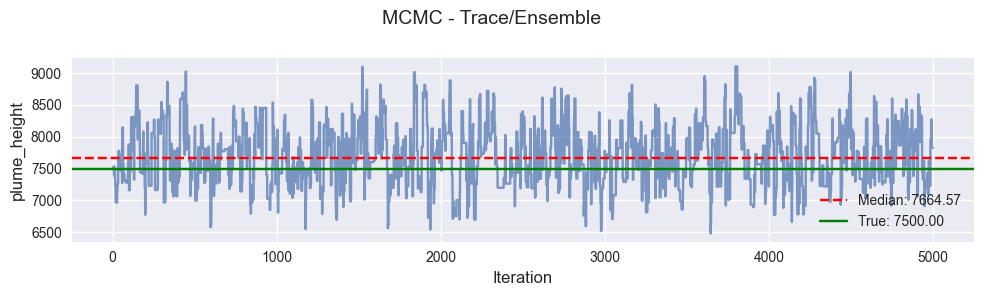


Posterior Summary Statistics:
      Parameter         Mean       Median      CI_2.5%     CI_97.5%
0  plume_height 7,706.459951 7,664.570229 6,855.818188 8,677.579316


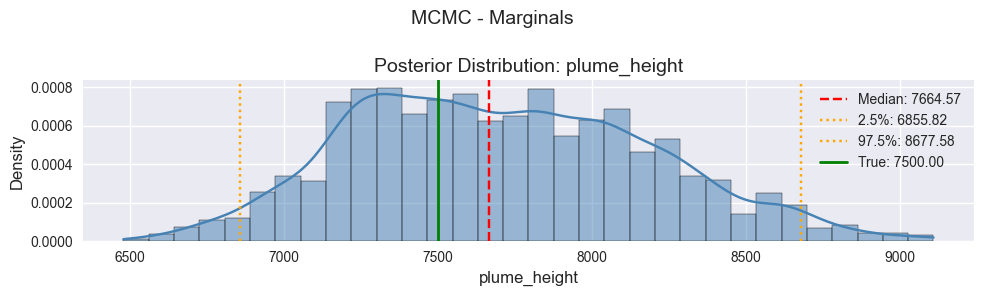


MCMC summary
------------------------
Point estimate:
 plume_height   7633.406105
log_mass         24.626134
Acceptance rate: 0.251


In [6]:
# Method 1: MCMC (defaults from config)
mcmc = TephraInversion(config={"method": "mcmc"})
mcmc_results = mcmc.run_inversion()
summarize_and_plot("MCMC", mcmc_results)

# SA (Simulated Annealing)

**What it does.** A **mode‑seeking** heuristic: accepts worse moves with probability $\exp(\Delta E / T)$; as temperature $T$ cools, the search becomes greedier.

* We use **adaptive cooling** if `alpha=None`:
  $T_{\text{end}} = T_0 \alpha^{\text{runs}} \Rightarrow \alpha = (T_{\text{end}}/T_0)^{1/\text{runs}}$.
  This avoids “temperature dies too fast” issues.

**When to use SA**

* You want a **good fit quickly** (not full uncertainty).
* As a **warm start** for MCMC.

**Interpreting output**

* The best posterior score should **improve** early, then plateau.
* Traces are single trajectories—no “mixing” concept here.

**If it stalls early**

* Raise `T0` or use a **slower** cooling (smaller `alpha`, or specify a larger `T_end`),
* Increase `runs` or add `restarts`.

2025-08-11 07:44:48,156 - scripts.tephra_inversion - INFO - TephraInversion initialized

[SA] Restart 1/1  (T0=1.0000, alpha=0.990000)
[SA] iter  5000/ 5000  T=0.0000  acc=0.011  h=7634.7  lnM=24.624  best=-108.8437


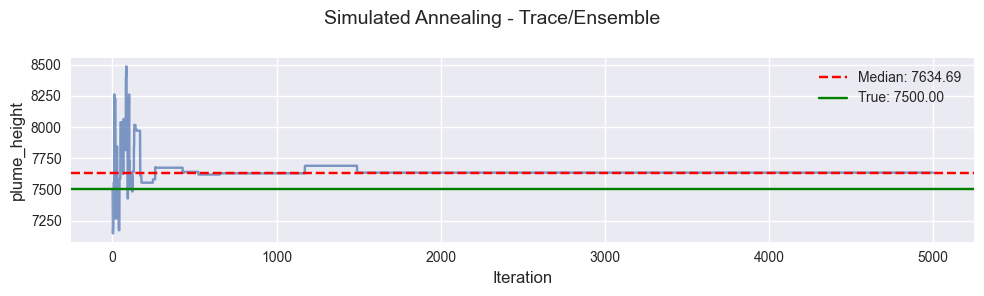


Posterior Summary Statistics:
      Parameter         Mean       Median      CI_2.5%     CI_97.5%
0  plume_height 7,641.995928 7,634.694052 7,580.978282 7,689.415655


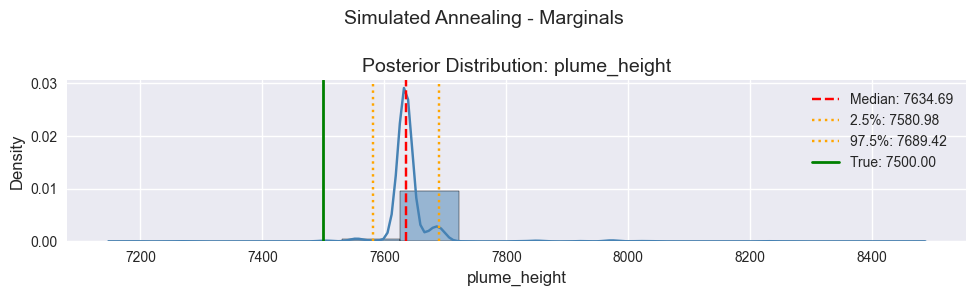


Simulated Annealing summary
------------------------
Point estimate:
 plume_height   7634.030571
log_mass         24.633843


In [7]:
# Method 2: SA (defaults from config; adaptive alpha)
sa = TephraInversion(config={"method": "sa"})
sa_results = sa.run_inversion()
summarize_and_plot("Simulated Annealing", sa_results)

# EnKF (Ensemble Kalman, smoother style)

**What it does.** Updates an ensemble over $K$ passes using Kalman‑style linear updates in observation space:

$$
K_k = C_{xy}(C_{yy} + R_k)^{-1}, \quad X \leftarrow X + (y + \varepsilon_k - \hat{y})K_k^\top.
$$

We split the observation noise as $R_k = K \cdot \sigma^2 I$ (EnKF convention).

**This implementation**

* Works in **log‑space** (like MCMC/SA),
* Adds **winsorization** & **ridge** to stabilize covariance inversions,
* Supports **inflation**, **trust region**, and **jitter** to prevent ensemble collapse.

**Interpreting progress lines**

* `valid=...` tells how many ensemble members produced finite predictions,
* `h_mean`, `lnM_mean` report **ensemble means** each pass (not posteriors).

**If ensembles misbehave**

* Increase `ridge_cyy` (more regularization),
* Use small `inflation` (e.g., 1.01–1.05),
* Increase `n_assimilations` (more, smaller steps),
* Check priors: too‑broad priors can make covariances unstable.

2025-08-11 07:46:25,469 - scripts.tephra_inversion - INFO - TephraInversion initialized
[ENKF] pass 1/5  iter 1000/1000
[ENKF] pass 1/5  valid=1000  h_mean=7,715.5  lnM_mean=24.659
[ENKF] pass 2/5  iter 1000/1000
[ENKF] pass 2/5  valid=1000  h_mean=7,784.8  lnM_mean=24.645
[ENKF] pass 3/5  iter 1000/1000
[ENKF] pass 3/5  valid=1000  h_mean=7,795.8  lnM_mean=24.640
[ENKF] pass 4/5  iter 1000/1000
[ENKF] pass 4/5  valid=1000  h_mean=7,792.6  lnM_mean=24.637
[ENKF] pass 5/5  iter 1000/1000
[ENKF] pass 5/5  valid=1000  h_mean=7,791.4  lnM_mean=24.636


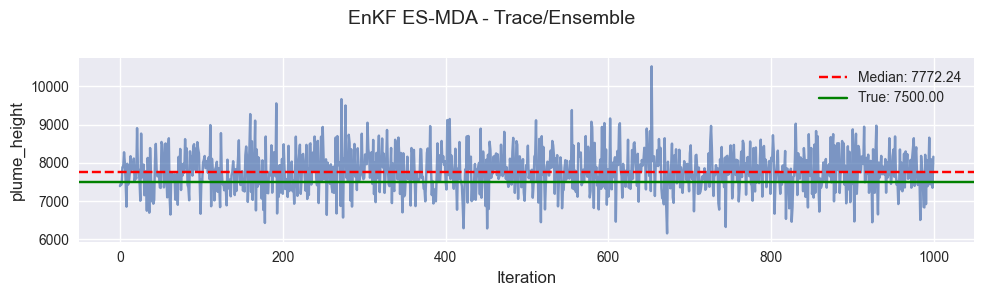


Posterior Summary Statistics:
      Parameter         Mean       Median      CI_2.5%     CI_97.5%
0  plume_height 7,791.420689 7,772.243969 6,760.196736 8,911.592354


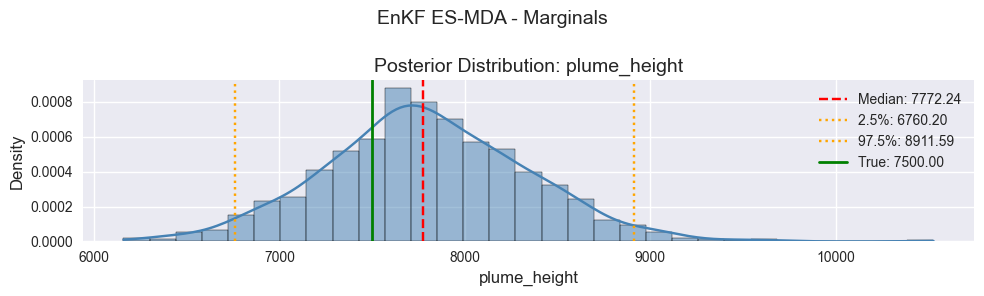


EnKF ES-MDA summary
------------------------
Point estimate:
 plume_height   7791.420689
log_mass         24.635700


In [8]:
# Method 3: EnKF / ES-MDA (defaults from config)
enkf = TephraInversion(config={"method": "enkf"})
enkf_results = enkf.run_inversion()
summarize_and_plot("EnKF ES-MDA", enkf_results)

# EnKF: Traces & Marginals (2×2)

This figure shows **how the ensemble evolves** across passes:

* **Top row (blue/green)**: traces of all members across passes (very light gray) with a **colored subset** highlighted (low opacity). This reveals:

  * the **scale** of variability,
  * whether members are **collapsing** too aggressively or meandering.

* **Bottom row**: per‑pass **marginals** (overlaid histograms) for each parameter. Later passes slightly darker:

  * you should see **progressive tightening** if data are informative,
  * or **little movement** if priors/data already agree.

**Good patterns**

* Gradual drift then stabilization,
* Marginals narrowing by the final pass without becoming pathological spikes.

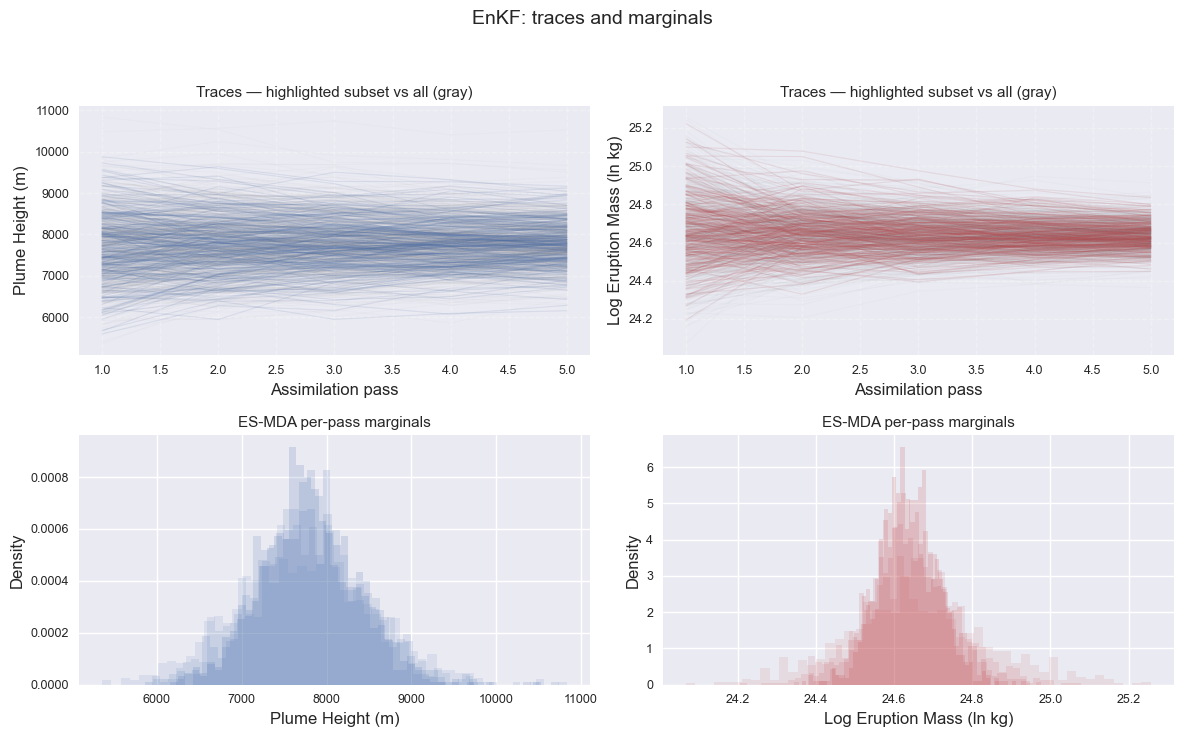

In [9]:
# After running ENKF and getting ensemble_history:
enkf_hist = enkf_results.get("ensemble_history", [])

if enkf_hist:
    enkf_pass_2x2(
        enkf_hist,
        param_indices=(0, 1),
        param_labels=("Plume Height (m)", "Log Eruption Mass (ln kg)"),
        title="EnKF: traces and marginals",
        save_path="data/output/plots/enkf_pass_2x2.png",
        show=True,
        max_color_series=256,  # colored subset; the rest are gray
        gray_alpha=0.015,
        color_alpha=0.10,
        bins=50,
        base_hist_alpha=0.10,
    )

# Comparing Methods: Table & Clouds

**Table**
We compare point estimates (and intervals where applicable). For MCMC, these are credible‑interval‑like summaries; for SA/EnKF they’re **diagnostic** (not posteriors).

**2D Cloud**
We overlay a **subsample** (low alpha) for readability:

* MCMC/SA: later iterations often darker (if you enabled that style).
* EnKF: final ensemble (or pass‑by‑pass if you choose to plot those).

**What’s a “good” result?**

* MCMC: traces mix; marginals are plausible; intervals aren’t absurdly tight.
* SA: final point aligns with physical expectations; neighboring proposals are worse.
* EnKF: ensemble shifts toward better fit without numerical blow‑ups.

In [10]:
# Quick table (only varying params)
table = summary_for_methods(mcmc_results, sa_results, enkf_results,
                            vary_only=("plume_height","log_mass"))
print("\nPoint estimates and intervals (varying parameters):")
display(table)


Point estimates and intervals (varying parameters):


,MCMC mean,MCMC 95% CI,SA point,EnKF mean,EnKF 95% CI
parameter,,,,,
plume_height,"7,706.459951","[6.86e+03, 8.68e+03]","7,634.030571","7,791.420689","[6.76e+03, 8.91e+03]"
log_mass,24.628693,"[24.5, 24.8]",24.633843,24.635700,"[24.5, 24.8]"


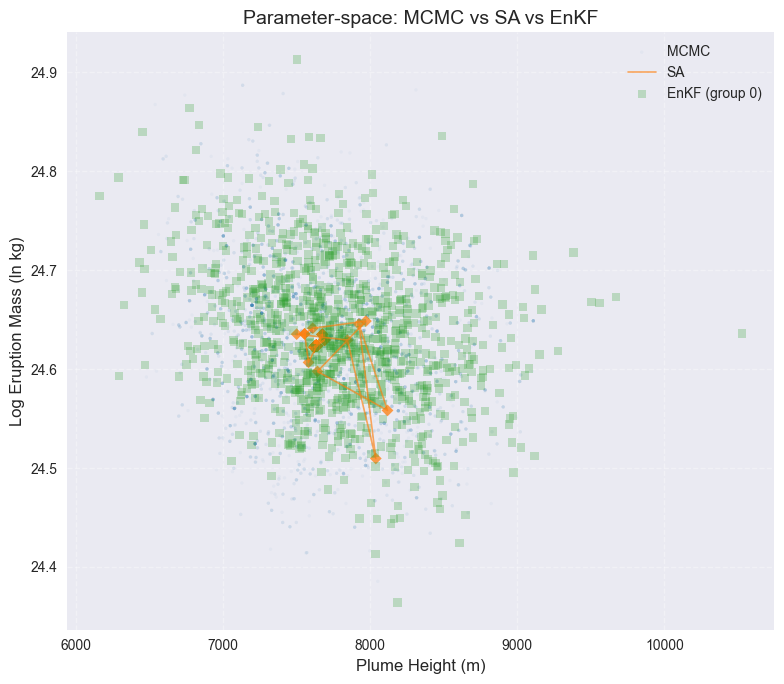

'data/output/plots/method_trajectories.png'

In [21]:
scatter_2d_progress(
    mcmc=mcmc_results,
    sa=sa_results,
    enkf=enkf_results,
    xparam="plume_height",
    yparam="log_mass",
    title="Parameter-space: MCMC vs SA vs EnKF",
    save_path="data/output/plots/method_trajectories.png",
    show=True,
    sa_step=25,
)

# Appendix

## Likelihood σ (why 0.6?) and what to try

We model **log‑residuals** as Gaussian with std **σ**. On many tephra problems:

* **σ ≈ 0.5–0.8** balances fit vs robustness in log‑space,
* **σ too small**: everything over‑penalized ⇒ chains freeze, SA/EnKF over‑contract,
* **σ too large**: under‑penalized ⇒ diffuse posteriors and wandering.

If you scale runs from \~5k to \~100k:

* try **σ ∈ \[0.4, 0.9]**,
* tune proposal scales (MCMC) and cooling (SA) accordingly,
* in EnKF, consider **more passes** and **lower inflation** if you reduce σ.

## Troubleshooting Cheatsheet

* **NaNs/infs**: usually bad inputs or numerics. Check `observations.csv`, wind levels, and priors; then increase `ridge_cyy` (EnKF).
* **MCMC acceptance < 0.1**: proposal steps too big; increase `n_iterations`.
* **MCMC acceptance > 0.5**: proposal steps too small; you’re under‑exploring.
* **SA stuck**: raise `T0` or use adaptive `alpha=None` with a larger `T_end`.
* **EnKF collapses**: reduce inflation or add jitter; increase passes.
* **Plots unreadable**: use subsampling and very low alpha (already baked in here).

You can always revert to defaults in `config/default_config.py` and change **one knob at a time**.